In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import urllib

In [49]:
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

In [50]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [51]:
import pandas as pd
df = pd.read_csv('usd-idr.csv', sep=',',
                     infer_datetime_format=True, index_col='Tanggal', header=0)

In [52]:
df.drop(["Pembukaan","Tertinggi","Terendah","Vol.","Perubahan%"], axis=1, inplace=True)

In [53]:
df.head()

,Terakhir
Tanggal,
1/25/2022,14350
1/24/2022,14340
1/21/2022,14335
1/20/2022,14335
1/19/2022,14360


In [28]:
data = df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))
SPLIT_TIME = int(len(data) * 0.7)
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]
print('Total Data sebanyak : ', df.size)
print('Data Train sebesar : ', x_train.size)
print('Data Test sebesar : ', x_valid.size)

Total Data sebanyak :  5000
Data Train sebesar :  3500
Data Test sebesar :  1500


In [29]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

In [30]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                            strides=1, padding="causal",
                            activation="relu",
                            input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
        ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = model.fit(train_set, epochs=150, callbacks=[lr_schedule], validation_data=valid_set)

Epoch 1/150


c:\Users\fawza\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


14/14 [==============================] - 14s 280ms/step - loss: 0.0369 - mae: 0.2373 - val_loss: 0.0021 - val_mae: 0.0587 - lr: 1.0000e-08
Epoch 2/150
14/14 [==============================] - 1s 62ms/step - loss: 0.0369 - mae: 0.2373 - val_loss: 0.0021 - val_mae: 0.0587 - lr: 1.1220e-08
Epoch 3/150
14/14 [==============================] - 1s 60ms/step - loss: 0.0369 - mae: 0.2373 - val_loss: 0.0021 - val_mae: 0.0587 - lr: 1.2589e-08
Epoch 4/150
14/14 [==============================] - 1s 61ms/step - loss: 0.0369 - mae: 0.2373 - val_loss: 0.0021 - val_mae: 0.0587 - lr: 1.4125e-08
Epoch 5/150
14/14 [==============================] - 1s 62ms/step - loss: 0.0369 - mae: 0.2373 - val_loss: 0.0021 - val_mae: 0.0587 - lr: 1.5849e-08
Epoch 6/150
14/14 [==============================] - 1s 62ms/step - loss: 0.0369 - mae: 0.2373 - val_loss: 0.0021 - val_mae: 0.0587 - lr: 1.7783e-08
Epoch 7/150
14/14 [==============================] - 1s 61ms/step - loss: 0.0369 - mae: 0.2373 - val_loss: 0.0021 - 

<Figure size 640x480 with 0 Axes>

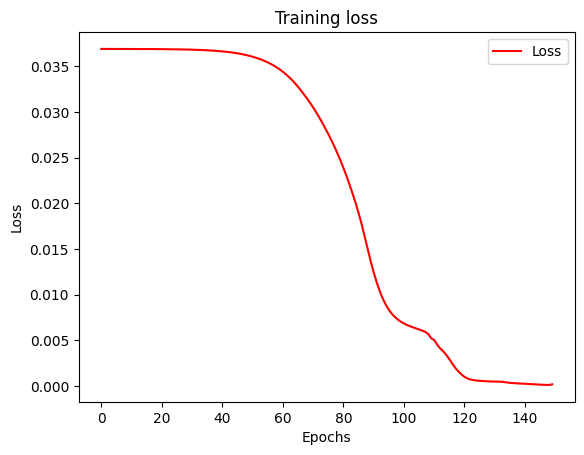

<Figure size 640x480 with 0 Axes>

In [34]:
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs
# — — — — — — — — — — — — — — — — — — — — — — — — 
# Plot training and validation loss per epoch
# — — — — — — — — — — — — — — — — — — — — — — — — 
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.figure()

In [35]:
def model_forecast(model, series, window_size):
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size))
 ds = ds.batch(32).prefetch(1)
 forecast = model.predict(ds)
 return forecast